In [3]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [4]:
%matplotlib inline

In [5]:
assets = ["AMZN", "SPY", "BAC", "CVX"]

In [6]:
# set number of assets (= number of qubits)

seed = 123

# assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

# Using data from yahoo finance
# use the name listed for particular company that you wish to add

import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(assets, start = '2013-01-01', end = '2021-12-31')['Adj Close']
selected_stocks_data.head()
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
# np.log(data/data.shift(1))
# log_return.head()


num_assets = len(assets)
mu = log_return.mean()*2741
sigma = log_return.cov()*2741
sigma = np.array(sigma)
mu = np.array(mu)

[*********************100%***********************]  4 of 4 completed


In [7]:
print("returns ", mu)
print("cov ", sigma)

returns  [3.1433081  1.79522951 0.55713849 1.6652048 ]
cov  [[0.97485555 0.28787789 0.20925661 0.30260436]
 [0.28787789 1.01496507 0.57750798 0.39905315]
 [0.20925661 0.57750798 0.88942357 0.3493556 ]
 [0.30260436 0.39905315 0.3493556  0.29670928]]


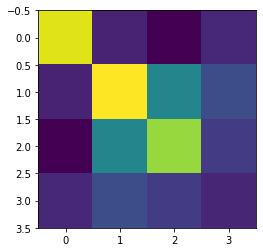

In [8]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [9]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.48742777596000547*x_0^2 + 0.28787789031618105*x_..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [10]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    # eigenstate = result.min_eigen_solver_result.eigenstate
    # eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    # probabilities = np.abs(eigenvector) ** 2
    # i_sorted = reversed(np.argsort(probabilities))
    # print("\n----------------- Full result ---------------------")
    # print("selection\tvalue\t\tprobability")
    # print("---------------------------------------------------")
    # for i in i_sorted:
    #     x = index_to_selection(i, num_assets)
    #     value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
    #     # value = portfolio.to_quadratic_program().objective.evaluate(x)
    #     probability = probabilities[i]
    #     row = [x, value, probability]
    #     writer.writerow(row)
        # print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [11]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname)


# [1. 0. 0. 1. 1. 0.]

Optimal: selection [1. 0. 0. 1.], value -3.8701


In [12]:
# VQE with Cobyla solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)



#[0. 0. 1. 1. 0. 1.] --numpy eigen solver

Optimal: selection [1. 0. 0. 1.], value -3.8701


In [13]:
# VQE with SPSA solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)
# print(result)

#[0. 0. 1. 1. 0. 1.] --numpy eigen solver

Optimal: selection [1. 0. 0. 1.], value -3.8701


In [14]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

Optimal: selection [1. 0. 0. 1.], value -3.8701


In [15]:
# QAOA wth SPSA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

Optimal: selection [1. 0. 0. 1.], value -3.8701


In [16]:
selected_assets = [1, 0, 0, 1]
assets = ["AMZN", "SPY", "BAC", "CVX"]
# [1. 0. 0. 1. 1. 0.]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['AMZN', 'CVX']


In [17]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2013-01-01', end = '2021-12-31')['Adj Close']
selected_stocks_data.head()


[*********************100%***********************]  2 of 2 completed


,AMZN,CVX
Date,,
2012-12-31,12.5435,72.065163
2013-01-02,12.8655,73.564545
2013-01-03,12.9240,73.251343
2013-01-04,12.9575,73.637848
2013-01-07,13.4230,73.138039


In [18]:
selected_assets = [1, 0, 0, 1]
assets = ["AMZN", "SPY", "BAC", "CVX"]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['AMZN', 'CVX']


In [19]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2013-01-01', end = '2021-12-31')['Adj Close']
selected_stocks_data.head()

[*********************100%***********************]  2 of 2 completed


,AMZN,CVX
Date,,
2012-12-31,12.5435,72.065155
2013-01-02,12.8655,73.564537
2013-01-03,12.9240,73.251343
2013-01-04,12.9575,73.637871
2013-01-07,13.4230,73.138069


In [20]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,AMZN,CVX
Date,,
2012-12-31,NaN,NaN
2013-01-02,0.025347,0.020592
2013-01-03,0.004537,-0.004266
2013-01-04,0.002589,0.005263
2013-01-07,0.035295,-0.006810


In [21]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.86876378 0.13123622]


In [22]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) *2741
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*2741,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [23]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [24]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [25]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.5, 0.2]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [26]:
neg_sharpe(weights)

-3.137205193967795

In [27]:
from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -3.183587694937867
     jac: array([-0.        ,  0.11909103])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.00000000e+00, 2.77555756e-16])

In [28]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [29]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [30]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'AMZN': 0.9999999999999998, 'CVX': 2.7755575615628914e-16}

In [31]:
my_assets

['AMZN', 'CVX']

In [32]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  1.0192537088882456


In [33]:
risk_ret_dict_of_quantum

{'returns': 28.898710032821022,
 'risk': 28.352813220902956,
 'sharpe_ratio': 1.0192537088882456}

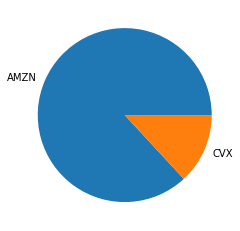

In [34]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [35]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [36]:
NUM_TRADING_DAYS = 2741 #252*5 cosnidered previously, now I'm just taing for 1 year
NUM_PORTFOLIOS = 10000
stocks = ["AMZN", "SPY", "BAC", "CVX"]

In [37]:
start_date = '2013-01-01' # YY/MM/DD
end_date = '2021-12-31'   # YY/MM/DD

In [38]:
def download_data():
    stocks_data = yf.download(stocks, start = '2013-1-1', end = '2021-12-31')['Adj Close']
    # stocks_data.head()
    return pd.DataFrame(stocks_data)

In [39]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [40]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [41]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [42]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [43]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [44]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [45]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [46]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [47]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [48]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [49]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [50]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


[*********************100%***********************]  4 of 4 completed


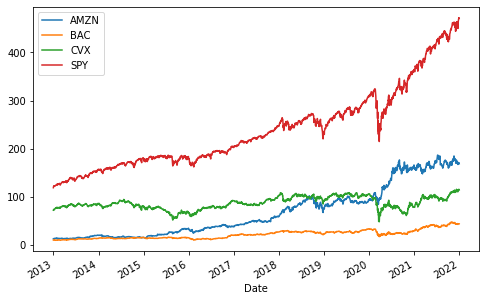

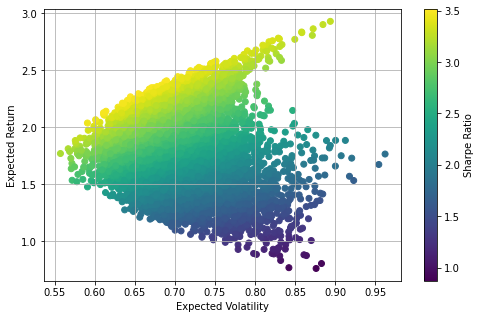

Optimal Portfolio:  [0.39 0.   0.   0.61]
Expected return, volatility and sharpe ratio:  [2.24166504 0.63455532 3.53265504]


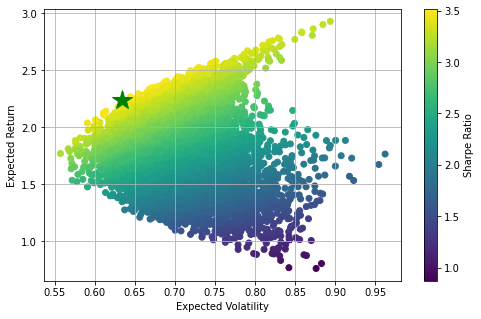

In [51]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [52]:
risk_ret_dict_of_quantum

{'returns': 28.898710032821022,
 'risk': 28.352813220902956,
 'sharpe_ratio': 1.0192537088882456}

[*********************100%***********************]  4 of 4 completed
AMZN    0.335075
BAC     0.179450
CVX     0.052556
SPY     0.165435
dtype: float64


Error: rescode.err_missing_license_file(1008): License cannot be located. The default search path is ';C:\Users\shrey\mosek\mosek.lic;'.

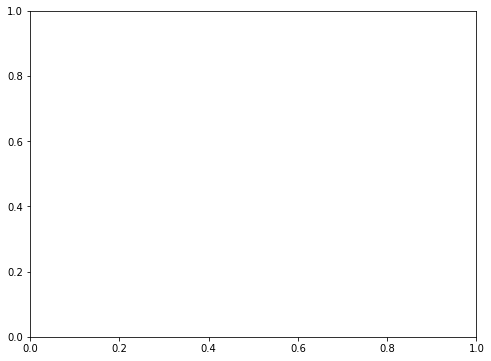

In [58]:
# !pip install pyportfolioopt


from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

stocks_df = yf.download(stocks, start = '2013-1-1', end = '2021-12-31')['Adj Close']
stocks_df.head()



mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)
print(mu)

def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
# fig_cum_returns.show()

corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
# fig_corr.show()

def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))